In [1]:
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
import numpy as np
import numpy.ma as ma

import scipy as sci
from scipy.stats import hypsecant
from astropy import constants as cst
from astropy import units as u
from astropy.coordinates import spherical_to_cartesian as StC
import time
import healpy as hp


from scipy.optimize import fsolve

from aqn import *
from constants import *


Loaded AQN script


### Natural $\longleftrightarrow$ physical units conversion factors

| Quantity | C.G.S | Natural ([erg]) |
| --- | --- | ------ |
| Length $\ell$ | [cm] | [erg$^{-1}$]=${[cm]\over \hbar c}$ |
| Time t | [s] | [erg$^{-1}$]=${[s]\over \hbar}$ |
| Mass m | [g] | [erg]=[g]c$^2$ |
| Velocity $\vec v$ | [cm$~$s$^{-1}$] | [1]=[cm$~$s$^{-1}$]$1\over c$ |
| Momentum $\vec p$ | [g$~$cm$~$s$^{-1}$] | [erg]=[g$~$cm$~$s$^{-1}$]c |
| Cross-section $\sigma$ | [cm$^2$] | [erg$^{-2}$]=${[cm]\over (\hbar c)^2}$ |
| Decay rate $\Gamma$| [s$^{-1}$] | [erg]=[s$^{-1}$]$\hbar$ |
| Frequency $\nu$| [Hz] | [erg]=[Hz]$\hbar$ |
| Temperature T| [K] | [erg]=[K]$k_B$ |

$1~{\rm eV} = 1.6021766\times 10^{-12}~{\rm erg}$

$1~{\rm GeV} = e~{\rm erg} = 0.0016021766~{\rm erg}$

$\hbar = 1.0545718×10^{−27}~{\rm erg~s} = 6.5821196×10^{−25}~{\rm GeV~s}$

$\hbar c = 3.1615268×10^{−17}~{\rm erg~cm} = 1.9732698×10^{−14}~{\rm GeV~cm}$

Some conversion factors:

$\ell_{\rm CGS} = \ell_{\rm Nat,erg^{-1}} (\hbar c)_{\rm CGS}=\ell_{\rm Nat,GeV^{-1}} {(\hbar c)_{\rm CGS}\over 0.0016021766} ~ \implies 1~{\rm GeV^{-1}}=1.9732698 \times 10^{-14}~{\rm cm}$

$t_{\rm CGS} = t_{\rm Nat,erg^{-1}} \hbar_{\rm CGS}=t_{\rm Nat,GeV^{-1}} {\hbar_{\rm CGS}\over 0.0016021766} ~ \implies 1~{\rm GeV^{-1}}=6.5821196\times10^{-25}~{\rm s}$



# AQN Emissivity Model

In [3]:
print("A nugget of radius 1e-5 cm has a mass of", calc_m_AQN(1e-5*u.cm))
print("A nugget of radius", calc_R_AQN(1*u.g), " cm has a mass of 1 g", )
print("A nugget of radius", calc_R_AQN(1*u.kg), " cm has a mass of 1 kg", )

print("selected mass:", m_AQN_kg)
print("radius:", R_AQN)

A nugget of radius 1e-5 cm has a mass of 0.9634217471008703 g
A nugget of radius 1.0124988024704139e-05 cm  cm has a mass of 1 g
A nugget of radius 0.00010124988024704137 cm  cm has a mass of 1 kg
selected mass: 1.0 kg
radius: 0.00010124988024704137 cm


In [18]:
T_gas_cold     = 3e4 / 2 * u.K * K_to_eV       # unused
T_gas_warm     = (3e4 + 1e5)/2 * u.K * K_to_eV
T_gas_warm_hot = (1e5 + 1e6)/2 * u.K * K_to_eV
T_gas_hot      = 1e6 * u.K * K_to_eV

print(F_tot(1*u.eV) / inverg_to_cm * cst.hbar.cgs * inverg_to_cm**3)
print(T_gas_cold / K_to_eV, T_AQN_analytical(n_bar, Dv, f, g))
print(T_gas_warm / K_to_eV, T_AQN_ionized(n_bar, Dv, f, g, T_gas_warm, R_AQN))
print(T_gas_warm_hot / K_to_eV, T_AQN_ionized(n_bar, Dv, f, g, T_gas_warm_hot, R_AQN))
print(T_gas_hot / K_to_eV, T_AQN_ionized(n_bar, Dv, f, g, T_gas_hot, R_AQN))
print(T_AQN_ionized(n_bar.to(1/u.m**3), Dv, f, g, T_gas_hot, R_AQN) )

1.9032627689555338e-54 erg4
15000.0 K 0.2845501127612687 eV
65000.0 K 311.21088552723967 eV
550000.0 K 10.212588822354915 eV
1000000.0 K 3.9238839088101987 eV
3.9238839088101987 eV


### Calculating spectral spatial emissivity $\epsilon$

#### Frequency range

In [17]:
wavel_min = 1350 * u.Angstrom
wavel_max = 1750 * u.Angstrom
print("Galex data is", wavel_min.value, "-", wavel_max)
f_max = (cst.c.cgs / wavel_min.to(u.cm)).to(u.Hz)
f_min = (cst.c.cgs / wavel_max.to(u.cm)).to(u.Hz)
print("    ","{:e}".format(f_min.to(u.GHz).value), "-", "{:e}".format(f_max.to(u.GHz)))

Galex data is 1350.0 - 1750.0 Angstrom
     1.713100e+06 - 2.220685e+06 GHz


# Disk-Bulge-Halo Milky Way Galaxy Model Number 5 - E2K

### Milky Way Galaxy Parameters


### Coded model parameters and number density functions

In [2]:
distance    = 8 * u.kpc                                                                     # distance to MW galaxy centre  [kpc]
galaxy_diameter = 30 * u.kpc
galaxy_height = 0.3 * u.kpc

# ----------- DM Halo Model -----------

rho_0h = 0.0106 * u.solMass / u.pc**3
r_h = 19.0 * u.kpc

def rho_halo(r,z):
    R = np.sqrt(r**2 + z**2)
    return rho_0h.to(u.kg/u.m**3) / ((R/r_h)*(1+R/r_h)**2)

def n_halo(r,z):
    return rho_halo(r*u.kpc,z*u.kpc) / m_AQN_kg



# -----------  E2K Gas Model -----------
[a1_c, b1_c, c1_c, 
 a2_c, b2_c, c2_c, 
 a3_c, b3_c, c3_c, 
 a4_c, b4_c, c4_c, 
 a5_c, b5_c, c5_c, 
 a6_c, b6_c, c6_c] = [30.04649796,  0.4079755,  3.77607598,  
              1e3,3e-1,15,
             2.6e4,5e-2,3,
             0,0,0,
             0,0,0,
             0,0,0,]

[a1_w, b1_w, c1_w, 
 a2_w, b2_w, c2_w, 
 a3_w, b3_w, c3_w, 
 a4_w, b4_w, c4_w, 
 a5_w, b5_w, c5_w, 
 a6_w, b6_w, c6_w] = [1.1e0,1e-1,0.22,
              1.7e1,12e-1,110,
              0.575e4,8.2e-2,13.7,
             0,0,0,
             0,0,0,
             0,0,0,]

[a1_wh, b1_wh, c1_wh, 
 a2_wh, b2_wh, c2_wh, 
 a3_wh, b3_wh, c3_wh, 
 a4_wh, b4_wh, c4_wh, 
 a5_wh, b5_wh, c5_wh, 
 a6_wh, b6_wh, c6_wh] = [6.1e1,4.4e-1,1.8,
              9e2,9.2e-2,2.8,
              1.5e4,7e-2,9,
             0,0,0,
             0,0,0,
             0,0,0,]

[a1_h, b1_h, c1_h, 
 a2_h, b2_h, c2_h, 
 a3_h, b3_h, c3_h, 
 a4_h, b4_h, c4_h, 
 a5_h, b5_h, c5_h, 
 a6_h, b6_h, c6_h] = [2e2,4e-1,9.5,
              1e4,10e-2,6,
              2.6e4,3e-2,3.1,
              0,0,0,
              0,0,0,
              0,0,0,]

from astropy.cosmology import WMAP7   # WMAP 7-year cosmology
rho_crit_z05_cgs = WMAP7.critical_density(0.5)  # critical density at z = 0.5  
rho_crit_z05_si = rho_crit_z05_cgs.to(u.kg / u.m**3)
r_vir_kpc = 233 * u.kpc

def rho_gas_component(r_kpc,z_kpc,gas_component):
    R_kpc = np.sqrt(r_kpc**2 + z_kpc**2)
    x = (R_kpc/r_vir_kpc).value
    if gas_component == "cold":
        return  (a1_c / (1+(x/b1_c)**2)**c1_c + \
                 a2_c / (1+(x/b2_c)**2)**c2_c + \
                 a3_c / (1+(x/b3_c)**2)**c3_c) * rho_crit_z05_si
    if gas_component == "warm":
        return  (a1_w / (1+(x/b1_w)**2)**c1_w + \
                 a2_w / (1+(x/b2_w)**2)**c2_w + \
                 a3_w / (1+(x/b3_w)**2)**c3_w) * rho_crit_z05_si
    if gas_component == "warm-hot":
        return  (a1_wh / (1+(x/b1_wh)**2)**c1_wh + \
                 a2_wh / (1+(x/b2_wh)**2)**c2_wh + \
                 a3_wh / (1+(x/b3_wh)**2)**c3_wh) * rho_crit_z05_si 
    if gas_component == "hot":
        return  (a1_h / (1+(x/b1_h)**2)**c1_h + \
                 a2_h / (1+(x/b2_h)**2)**c2_h + \
                 a3_h / (1+(x/b3_h)**2)**c3_h) * rho_crit_z05_si 

def n_gas_component(r,z, gas_component):
    return rho_gas_component(r*u.kpc,z*u.kpc,gas_component) / cst.m_p.si


def rho_gas(r_kpc,z_kpc):
    return rho_gas_component(r_kpc,z_kpc,"cold") + rho_gas_component(r_kpc,z_kpc,"warm") + rho_gas_component(r_kpc,z_kpc,"warm-hot") + rho_gas_component(r_kpc,z_kpc,"hot")

def n_gas(r,z):
    return rho_gas(r*u.kpc,z*u.kpc) / cst.m_p.si


print("Critical density at redshift z=0.5 is", rho_crit_z05_cgs)
    
print(n_gas(8,0).cgs)

Critical density at redshift z=0.5 is 1.532639674691421e-29 g / cm3
0.1809470850312699 1 / cm3


In [3]:
r_min_kpc = distance*np.sin(np.radians(17))

# Sightline Integrals


In [4]:
# coord_conv([8, np.pi/2, np.pi])

In [5]:
# D = distance.value

# def coord_conv(V): # check you get 0 when aiming at galactic centre
#     l, theta, phi = V[0], V[1], V[2]
#     #print(l,D)
#     x0 = l*np.sin(theta)*np.cos(phi) + D # *cos(azimuth)?         # potential sign error                                                                                                                       !!
#     y0 = l*np.sin(theta)*np.sin(phi)     # - D *sin(azimuth)?                                                                                                                            !!
#     z0 = l*np.cos(theta)
#     return [np.sqrt(x0**2 + y0**2), z0]
# # offcentre density profiles - analytic coordinate transformation

# # This is the resolution of the skymap.
# # Pick tesselation parameter, pos power of 2.
# NSIDE = 2**0

# # Number of pixels in the skymap
# NPIX = hp.nside2npix(NSIDE)   
# print("Tesselation parameter is", NSIDE, "so skymap has", NPIX, "pixels.")

# # Solid angle of a single pixel:
# dOmega = hp.nside2pixarea(nside=NSIDE)
# print("Solid angle of a single pixel is", round(dOmega,3), "steradians.")
# print("Sanity check:", NPIX, "pixels x", round(dOmega,3), "sr =", round(hp.nside2pixarea(nside=NSIDE)*NPIX,3), "sr, which is 4pi =",round(np.pi*4,3))

# # dOmega = dA / D^2 so:
# dA = dOmega * 5**2
# print("Area in the sky at 5 kpc is dA =", round(dA, 3), "kpc^2")

### Example - Flux in a length element of a solid angle

In [6]:
# nu = (1 * u.GHz).to(u.Hz)

# # Now pick a pixel to work with.
# theta, phi = hp.pix2ang(nside=NSIDE, ipix=[0])
# print(np.degrees(theta), np.degrees(phi[0]))

# # Now let's just take something 5 kpc away from earth. The corresponding r,z rel to the centre of MW are:
# r,z = coord_conv([0.2, theta[0], phi[0]])
# print("--","r=",r,"z=",z)

# dr = 1 * u.cm

# # Flux at that solid angle at that distance is:
# ## dF = spectral_spatial_emissivity(n_halo(r,z), n_disk(r,z), Dv, f, g, nu) * dr * dOmega / (4*np.pi)
# dF = spectral_spatial_emissivity(n_halo(r,z), n_gas(r,z), Dv, f, g, nu) * dr * dOmega / (4*np.pi)

# print("Flux is", dF)
# print(n_halo(r,z), "||||||", n_AQN.to(1/u.m**3))
# print(n_gas(r,z), "||||||", n_bar.to(1/u.m**3))
# spectral_spatial_emissivity(n_AQN.to(1/u.m**3), n_bar, Dv, f, g, nu)

# #distance_to_edge(theta[0],phi[0])

In [7]:
print(R_eff(R_AQN,1*u.eV, 1*u.eV), R_AQN)

0.5926286282378298 cm 0.00010124988024704137 cm


## Function to integrate

In [8]:
# nu = 2e15*u.Hz


# def spectral_spatial_emissivity_cold(n_AQN, n_bar, Dv, f, g, nu):
#     T_AQN = T_AQN_analytical(n_bar, Dv, f, g)
#     #print(T_AQN)
#     #T_AQN = 1 * u.eV ########################################################
#     dFdw = spectral_surface_emissivity(nu, T_AQN)
#     #print("Cold Gas, neutral temp: ", T_AQN, "   Density: ", n_bar.to(1/u.cm**3))
#     return dFdw * 4 * np.pi * R_AQN**2 * n_AQN.to(1/u.cm**3)

# def spectral_spatial_emissivity_hot(n_AQN, n_bar, Dv, f, g, T_gas, R_AQN, nu):
#     T_ionized = T_AQN_ionized(n_bar, Dv, f, g, T_gas, R_AQN)
#     T_neutral = T_AQN_analytical(n_bar, Dv, f, g)
#     T_AQN = max(T_neutral, T_ionized)
#     #print(T_AQN)
#     #T_AQN = 1 * u.eV ########################################################
#     dFdw = spectral_surface_emissivity(nu, T_AQN)
#     #print("Gas Temp: ", T_gas/K_to_eV,  "     Density: ", n_bar.to(1/u.cm**3), "    Ionized temp: ",T_ionized, "     Neutral temp: ", T_neutral, "    Selected temp: ", T_AQN)
#     #print(n_bar.to(1/u.cm**3))
#     return dFdw * 4 * np.pi * R_AQN**2 * n_AQN.to(1/u.cm**3) #                                                    !!!!!!!!!!!!!!!!!!



# def func(l, theta, phi):
#     r,z = coord_conv([l, theta, phi])
#     #print(np.sqrt(r**2 + z**2), l)
#     n_cold     = n_gas_component(r,z, "cold")
#     T_cold     = T_gas_cold
    
#     n_warm     = n_gas_component(r,z, "warm")
#     T_warm     = T_gas_warm
    
#     n_warm_hot = n_gas_component(r,z, "warm-hot")
#     T_warm_hot = T_gas_warm_hot
    
#     n_hot      = n_gas_component(r,z, "hot")
#     T_hot      = T_gas_hot
    
#     n_aqn = n_halo(r,z)

#     epsilon = (spectral_spatial_emissivity_cold(n_aqn, n_cold, Dv, f, g, nu) +
#                spectral_spatial_emissivity_hot(n_aqn, n_warm,     Dv, f, g, T_warm,     R_AQN, nu) +
#                spectral_spatial_emissivity_hot(n_aqn, n_warm_hot, Dv, f, g, T_warm_hot, R_AQN, nu) +
#                spectral_spatial_emissivity_hot(n_aqn, n_hot,      Dv, f, g, T_hot, R_AQN, nu))
#     # spectral_spatial_emissivity_hot(n_aqn, n_cold,     Dv, f, g, T_cold,     R_AQN, nu) +
#     # 
#     #print("-",epsilon)
    
#     return epsilon.value


# sci.integrate.quad(func,0,r_vir_kpc.value,(theta,phi))[0] / (4*np.pi) *  u.kpc * (u.erg / u.Hz / u.s / u.cm**3 / u.sr) * kpc_to_cm * dOmega

# #print(spectral_spatial_emissivity(n_AQN, n_gas(1,1), Dv, f, g, nu), spectral_spatial_emissivity_cold(n_AQN, n_gas_component(1,1,"cold"), Dv, f, g, nu), spectral_spatial_emissivity_hot(n_AQN, n_bar, Dv, f, g, T_gas_warm, R_AQN, nu))

# # u.kpc.cgs


## Calculating flux from each solid angle for a particular frequency

In [9]:


# flux_array = np.zeros(NPIX)
# dOmega = hp.nside2pixarea(nside=NSIDE)
# for i in list(range(NPIX)):
#     #if i==6:
#     theta, phi = hp.pix2ang(nside=NSIDE, ipix=[i])
#     l_max = (r_vir_kpc).value ## distance_to_edge(theta, phi)
#     r,z = coord_conv([l_max, theta, phi])
#     flux_array[i] = (sci.integrate.quad(func,0,l_max,(theta,phi))[0] / (4*np.pi) * u.kpc * (u.erg / u.Hz / u.s / u.cm**3 / u.sr) * kpc_to_cm ).value # dOmega * u.sr
#     print("Pixel #"+str(i))
#     print(" Theta:", np.degrees(theta))
#     print(" Phi:  ", np.degrees(phi))    
#     print(" Distance to edge:", l_max)
#     print(" r:    ", r)
#     print(" z:    ", z)
#     print(" Flux:", flux_array[i]* (u.erg / u.Hz / u.s / u.cm**2 / u.sr))
#     print("\n")

# #sum(flux_array)
# #flux_array_HIGH = flux_array

## Integrating over Galex FUV Band

In [10]:

# # erg Hz^-1 s^-1 cm^-2
# # nu Hz
# # T eV
# def spectral_surface_emissivity(nu, T):
#     T = T * eV_to_erg
#     w = 2 * np.pi * nu * Hz_to_erg
#     unit_factor = (1 / cst.hbar.cgs) * (1/(cst.hbar.cgs * cst.c.cgs))**2 * (cst.hbar.cgs * 1/u.Hz * 1/u.s)
#     #                ^ 1/seconds           ^ 1/area                          ^ 1/frequency and energy
#     #print(np.array(w/T))
#     return unit_factor * 4/45 * T**3 * cst.alpha ** (5/2) * 1/np.pi * (T/(m_e_eV*eV_to_erg))**(1/4) * (1 + w/T) * np.exp(- w/T) * h(w/T)


# def spectral_spatial_emissivity_cold(n_AQN, n_bar, Dv, f, g, nu):
#     t_i = time.time()
#     T_AQN = T_AQN_analytical(n_bar, Dv, f, g)
#     # print("Time taken 0: ", time.time() - t_i)
#     #print(T_AQN)
#     #T_AQN = 1 * u.eV ########################################################
#     dFdw = spectral_surface_emissivity(nu, T_AQN)
#     return dFdw * 4 * np.pi * R_AQN**2 * n_AQN.to(1/u.cm**3)

# def spectral_spatial_emissivity_hot(n_AQN, n_bar, Dv, f, g, T_gas, R_AQN, nu):
#     t_i = time.time()
#     T_AQN = max(T_AQN_analytical(n_bar, Dv, f, g), T_AQN_ionized(n_bar, Dv, f, g, T_gas, R_AQN))
#     # print("Time taken: ", time.time() - t_i)
#     t_i = time.time()
#     dFdw = spectral_surface_emissivity(nu, T_AQN)
#     # print("Time taken 2: ", time.time() - t_i)
#     return dFdw * 4 * np.pi * R_AQN**2 * n_AQN.to(1/u.cm**3)





# def func(l, theta, phi, nu):
#     t_tot = time.time()
#     t_i = time.time()
#     r,z = coord_conv([l, theta, phi])
#     # print("1",time.time() - t_i)
    
#     t_i = time.time()
#     n_cold     = n_gas_component(r,z, "cold")
#     #T_cold     = T_gas_cold
#     # print("2",time.time() - t_i)
    
#     t_i = time.time()
#     n_warm     = n_gas_component(r,z, "warm") # avoid setting variables
#     T_warm     = T_gas_warm
#     # print("3",time.time() - t_i)
    
#     t_i = time.time()
#     n_warm_hot = n_gas_component(r,z, "warm-hot")
#     T_warm_hot = T_gas_warm_hot
#     # print("4",time.time() - t_i)
    
#     t_i = time.time()
#     n_hot      = n_gas_component(r,z, "hot")
#     T_hot      = T_gas_hot
#     # print("5",time.time() - t_i)
    
#     t_i = time.time()
#     n_aqn = n_halo(r,z)
#     # print("6",time.time() - t_i)
    
#     t_i = time.time()
#     epsilon = (spectral_spatial_emissivity_cold(n_aqn, n_cold, Dv, f, g, nu) +
#                spectral_spatial_emissivity_hot(n_aqn, n_warm,     Dv, f, g, T_warm,     R_AQN, nu) +
#                spectral_spatial_emissivity_hot(n_aqn, n_warm_hot, Dv, f, g, T_warm_hot, R_AQN, nu) +
#                spectral_spatial_emissivity_hot(n_aqn, n_hot,      Dv, f, g, T_hot, R_AQN, nu))
#     return epsilon.value

# def response_func(wavelength):
#     return 1 #wavelength/(wavel_max - wavel_min).value



# def h(x):
#     return_array = np.zeros(len(x))
#     return_array[np.where(x<1)] = (17 - 12*np.log(x[np.where(x<1)]/2))
#     return_array[np.where(x>=1)] = 17 + 12*np.log(2)
#     return return_array
# def spectral_spatial_emissivity_hot(n_AQN, n_bar, Dv, f, g, T_gas, R_AQN, nu):
#     T_neu_eV = T_AQN_analytical(n_bar, Dv, f, g)
#     T_ion_eV = T_AQN_ionized(n_bar, Dv, f, g, T_gas, R_AQN)
#     #print(T_neu_eV, T_ion_eV)
#     T_AQN = T_neu_eV.copy()                   # don't need this, use T_neu_eV
#     ion_greater_neu = np.where(T_ion_eV > T_neu_eV)
#     T_AQN[ion_greater_neu] = T_ion_eV[ion_greater_neu]
#     #print(T_AQN)
#     #T_AQN = max(T_AQN_analytical(n_bar, Dv, f, g), T_AQN_ionized(n_bar, Dv, f, g, T_gas, R_AQN))
    
#     #T_AQN = 
    
#     dFdw = spectral_surface_emissivity(nu, T_AQN)
#     return dFdw * 4 * np.pi * R_AQN**2 * n_AQN.to(1/u.cm**3)


# # array of distance elements along each sightline
# dz = 1e-3 * u.kpc
# l_min, l_max = 0, (r_vir_kpc).value
# z_list = np.arange(l_min,l_max,dz.value)
# def sum_epsilon(l_min,l_max,theta,phi,nu):
#     dfdnu = sum(func(z_array, theta, phi, nu))
#     return dfdnu / (4*np.pi) * (dz.cgs).value * dOmega

# # 2D array - 1 for wavelength 1 for pixel (+ use theta, phi arrays) --> 1D array
# # work with log(func), will need fewer sampling points -- need to add correction factor (just analytic)

# def integrate_band(wavelength, theta, phi, l_max):
#     t_i = time.time()
#     # obtain frequency from wavelength
#     nu = (cst.c / (wavelength*u.Angstrom).to(u.m)).to(u.Hz) # calculate outside

#     # flux in erg / cm2 s sr Hz
#     dfdnu = sum_epsilon(0,l_max,theta,phi,nu)               
#     #dfdnu = (sci.integrate.romberg(func,0,l_max,(theta,phi,nu))[0] / (4*np.pi) * kpc_to_cm.value * dOmega)
#                                                                               #* u.kpc * (u.erg / u.Hz / u.s / u.cm**3 / u.sr)
#     #print(theta,phi,nu)
#     #dfdnu = (sci.integrate.romberg(func,0,l_max,(theta,phi,nu)) / (4*np.pi) * kpc_to_cm.value)
#     # flux in photon / cm2 s sr Angstrom
#     dfdlambda = (dfdnu * u.erg/u.s/u.Hz/u.cm**2/u.sr).to(u.photon / u.cm**2 / u.s / u.Angstrom / u.sr, u.spectral_density(wavelength * u.Angstrom)).value
#     # take conversion factors from a pre-calculated array
    
#     # print(dfdlambda)
#     #t_f = time.time()
#     #print("time: ", t_f-t_i)
#     print("for wavelength ", wavelength,dfdlambda, time.time()-t_i)

#     return dfdlambda * response_func(wavelength)
# # sample ~10 wavelengths


# #sum_epsilon(0,l_max,0,0,10000000*u.Hz)
# # func(np.array([0.001,2,3,4,5,10000]), 0, 0, 10000000*u.Hz)

# plt.figure(figsize=(8, 6), dpi=100)

# dz_array = np.logspace(-4,-1,20)
# epsilon = dz_array.copy()
# for i in range(len(dz_array)):
#     dz = dz_array[i] * u.kpc
#     print(dz)
#     epsilon[i] = sum_epsilon(0,l_max,0,1,2e15*u.Hz)
    
# plt.plot(dz_array, epsilon)
# plt.xscale("log")
# plt.xlabel("dz [kpc]",size=15)
# plt.savefig("picking_summation_dz.png")
# plt.ylabel("dF/dnu [erg/cm$^2\cdot$Hz$\cdot$s]",size=15)

# plt.show()

# dz = 1e-3 * u.kpc



In [11]:
# theta, phi = hp.pix2ang(nside = NSIDE, ipix = list(range(NPIX)))
# low_lat_filter = (np.degrees(theta) > 73) & (np.degrees(theta) < 113)
# ((np.degrees(theta) > 73) & (np.degrees(theta) < 113))

In [12]:
# NSIDE = 2**2
# NPIX = hp.nside2npix(NSIDE)
# wavelength_band_resolution = 30

# # array of theta, phi, for each pixel
# theta, phi = hp.pix2ang(nside = NSIDE, ipix = list(range(NPIX)))
# low_lat_filter = (np.degrees(theta) > 73) & (np.degrees(theta) < 113)
# #phi = phi[high_lat_filter]
# #theta = theta[high_lat_filter]

# # array for wavelengths in galex waveband
# wavelength_band = np.arange(wavel_min.value, wavel_max.value, wavelength_band_resolution)
# frequency_band = (cst.c / (wavelength_band*u.Angstrom).to(u.m)).to(u.Hz)

# # array of distance elements along each sightline
# dz = 1e-3 * u.kpc
# l_min, l_max = 0, (r_vir_kpc).value
# z_list = np.arange(l_min,l_max,dz.value)

# # z_array * np.sin(theta)*np.cos(phi) + D

# # def coord_conv(V): # check you get 0 when aiming at galactic centre
# #     l, theta, phi = V[0], V[1], V[2]
# #     #print(l,D)
# #     x0 = l*np.sin(theta)*np.cos(phi) + D # *cos(azimuth)?         # potential sign error                                                                                                                       !!
# #     y0 = l*np.sin(theta)*np.sin(phi)     # - D *sin(azimuth)?                                                                                                                            !!
# #     z0 = l*np.cos(theta)
# #     return [np.sqrt(x0**2 + y0**2), z0]
# # offcentre density profiles - analytic coordinate transformation


# # sum_epsilon(0,l_max,theta,phi,frequency_band) 

# #np.array([[theta],[phi],[z_array]])[0]

# z_array = np.ones((len(theta),len(z_list))) * z_list
# z_array[low_lat_filter] = 0
# #test[(np.degrees(theta) > 73) & (np.degrees(theta) < 113)] = z_array
# z_array[0] * np.sin(theta[0]) * np.cos(phi[0]) + D
# #test * np.sin(np.ones((len(theta),len(z_array)) * theta))# * np.cos(phi) + D
# #np.ones((len(theta),len(z_array))) * z_array * np.sin(theta)

In [13]:
# z_array.transpose() * np.tile(np.sin(theta).transpose() * np.cos(phi).transpose(), (len(z_list),1)) + D

In [14]:
# #T_AQN = 1000* u.eV

# NSIDE = 2**2
# # Number of pixels in the skymap
# NPIX = hp.nside2npix(NSIDE)

# # create empty flux array based on pixel resolution
# flux_array = np.zeros(NPIX)
# dOmega = hp.nside2pixarea(nside=NSIDE)
# l_max = (r_vir_kpc).value

# # for each pixel:
# for i in list(range(NPIX)):
#     theta, phi = hp.pix2ang(nside=NSIDE, ipix=[i])          # as array
#     if np.degrees(theta)>73 and np.degrees(theta)<113:      # filter out
#         flux_array[i] = 0
#     else:
#     # integrate over Galex FUV Band
#         print("integrating...", theta, phi, l_max)
#         ti = time.time()
#         flux_array[i] = sci.integrate.quad(integrate_band,wavel_min.value,wavel_max.value,(theta, phi, l_max))[0] # sum
#         #print(tf-ti)
#     print(flux_array[i], time.time() - ti)
# #    2.328713137077407e-16

# # l_max distance
# # integration precision (change from default?)
# # try integrate each of 4 separately (does 1 take longest?)


## Optimizing Summation

In [15]:
distance    = 8 * u.kpc                                                               # distance to MW galaxy centre  [kpc]
D = distance.value
galaxy_diameter = 30 * u.kpc
galaxy_height = 0.3 * u.kpc

# ----------- DM Halo Model -----------

rho_0h = 0.0106 * u.solMass / u.pc**3
r_h = 19.0 * u.kpc

def rho_halo(R_kpc):
    return rho_0h.to(u.kg/u.m**3) / ((R_kpc/r_h)*(1+R_kpc/r_h)**2)

def n_halo(R_none):
    return rho_halo(R_none*u.kpc) / m_AQN_kg



# -----------  E2K Gas Model -----------
[a1_c, b1_c, c1_c, 
 a2_c, b2_c, c2_c, 
 a3_c, b3_c, c3_c, 
 a4_c, b4_c, c4_c, 
 a5_c, b5_c, c5_c, 
 a6_c, b6_c, c6_c] = [30.04649796,  0.4079755,  3.77607598,  
              1e3,3e-1,15,
             2.6e4,5e-2,3,
             0,0,0,
             0,0,0,
             0,0,0,]

[a1_w, b1_w, c1_w, 
 a2_w, b2_w, c2_w, 
 a3_w, b3_w, c3_w, 
 a4_w, b4_w, c4_w, 
 a5_w, b5_w, c5_w, 
 a6_w, b6_w, c6_w] = [1.1e0,1e-1,0.22,
              1.7e1,12e-1,110,
              0.575e4,8.2e-2,13.7,
             0,0,0,
             0,0,0,
             0,0,0,]

[a1_wh, b1_wh, c1_wh, 
 a2_wh, b2_wh, c2_wh, 
 a3_wh, b3_wh, c3_wh, 
 a4_wh, b4_wh, c4_wh, 
 a5_wh, b5_wh, c5_wh, 
 a6_wh, b6_wh, c6_wh] = [6.1e1,4.4e-1,1.8,
              9e2,9.2e-2,2.8,
              1.5e4,7e-2,9,
             0,0,0,
             0,0,0,
             0,0,0,]

[a1_h, b1_h, c1_h, 
 a2_h, b2_h, c2_h, 
 a3_h, b3_h, c3_h, 
 a4_h, b4_h, c4_h, 
 a5_h, b5_h, c5_h, 
 a6_h, b6_h, c6_h] = [2e2,4e-1,9.5,
              1e4,10e-2,6,
              2.6e4,3e-2,3.1,
              0,0,0,
              0,0,0,
              0,0,0,]

from astropy.cosmology import WMAP7   # WMAP 7-year cosmology
rho_crit_z05_cgs = WMAP7.critical_density(0.5)  # critical density at z = 0.5  
rho_crit_z05_si = rho_crit_z05_cgs.to(u.kg / u.m**3)
r_vir_kpc = 233 * u.kpc

def rho_gas_component(R_kpc,gas_component):
    x = (R_kpc/r_vir_kpc).value
    if gas_component == "cold":
        return  (a1_c / (1+(x/b1_c)**2)**c1_c + \
                 a2_c / (1+(x/b2_c)**2)**c2_c + \
                 a3_c / (1+(x/b3_c)**2)**c3_c) * rho_crit_z05_si
    if gas_component == "warm":
        return  (a1_w / (1+(x/b1_w)**2)**c1_w + \
                 a2_w / (1+(x/b2_w)**2)**c2_w + \
                 a3_w / (1+(x/b3_w)**2)**c3_w) * rho_crit_z05_si
    if gas_component == "warm-hot":
        return  (a1_wh / (1+(x/b1_wh)**2)**c1_wh + \
                 a2_wh / (1+(x/b2_wh)**2)**c2_wh + \
                 a3_wh / (1+(x/b3_wh)**2)**c3_wh) * rho_crit_z05_si 
    if gas_component == "hot":
        return  (a1_h / (1+(x/b1_h)**2)**c1_h + \
                 a2_h / (1+(x/b2_h)**2)**c2_h + \
                 a3_h / (1+(x/b3_h)**2)**c3_h) * rho_crit_z05_si 

def n_gas_component(R_none, gas_component):
    return rho_gas_component(R_none*u.kpc, gas_component) / cst.m_p.si


def rho_gas(R_none):
    return rho_gas_component(R_none,"cold") + rho_gas_component(R_none,"warm") + rho_gas_component(R_none,"warm-hot") + rho_gas_component(R_none,"hot")

def n_gas(R_none):
    return rho_gas(R_none) / cst.m_p.si


print("Critical density at redshift z=0.5 is", rho_crit_z05_cgs)
    
print(n_gas(8).cgs)

Critical density at redshift z=0.5 is 1.532639674691421e-29 g / cm3
0.1809470850312699 1 / cm3


In [19]:
# some resolution parameters
NSIDE = 2**4
wavelength_band_resolution = 30
NPIX = hp.nside2npix(NSIDE)
dOmega = hp.nside2pixarea(nside=NSIDE)

# array of theta, phi, for each pixel
theta, phi = hp.pix2ang(nside = NSIDE, ipix = list(range(NPIX)))
low_lat_filter = (np.degrees(theta) > 73) & (np.degrees(theta) < 113)
high_lat_filter = (np.degrees(theta) < 73) | (np.degrees(theta) > 113)

# array for wavelengths in galex waveband
wavelength_band = np.arange(wavel_min.value, wavel_max.value, wavelength_band_resolution)
frequency_band = (cst.c / (wavelength_band*u.Angstrom).to(u.m)).to(u.Hz)
conversion_array = (1*u.erg/u.s/u.Hz/u.cm**2/u.sr).to(u.photon / u.cm**2 / u.s / u.Angstrom / u.sr, u.spectral_density(wavelength_band*u.Angstrom))

# array of distance elements
dl = 2 * u.kpc # 1e-3 * u.kpc
l_min, l_max = 0, (r_vir_kpc).value
l_list = np.arange(l_min,l_max,dl.value)[:, np.newaxis]

# 2D array of distance elements along each sightline, sun-centric
l_array = np.ones((len(l_list),len(theta))) * l_list
l_array[:,low_lat_filter] = 0

# 2D array of distance elements along each sightline, galaxy-centric
x = l_array * np.sin(theta) * np.cos(phi) + D
y = l_array * np.sin(theta) * np.sin(phi)
z = l_array * np.cos(theta)
R_array = np.sqrt(x**2 + y**2 + z**2)

# calculate mass densities of each gas component
n_cold     = n_gas_component(R_array, "cold") 

n_warm     = n_gas_component(R_array, "warm") # avoid setting variables
T_warm     = T_gas_warm

n_warm_hot = n_gas_component(R_array, "warm-hot")
T_warm_hot = T_gas_warm_hot

n_hot      = n_gas_component(R_array, "hot")
T_hot      = T_gas_hot


# calculate AQN number density
n_aqn = n_halo(R_array)


# select a single frequency for now, later will be a bandwidth array
nu = wavel_min.to(u.Hz, equivalencies = u.spectral())


In [20]:
h_func_cutoff = 17 + 12*np.log(2)
def h(x):
    return_array = np.copy(x)
    return_array[np.where(x<1)] = (17 - 12*np.log(x[np.where(x<1)]/2))
    return_array[np.where(x>=1)] = h_func_cutoff
    return return_array

In [45]:
spectral_surface_emissivity_u_factor = (1 / cst.hbar.cgs) * (1/(cst.hbar.cgs * cst.c.cgs))**2 * (cst.hbar.cgs * 1/u.Hz * 1/u.s)
def spectral_surface_emissivity(T, frequency_band):
    T = T * eV_to_erg
    w_div_T = (2*np.pi*Hz_to_erg)*frequency_band[None,None,:] * (np.ones((len(l_list),len(theta), len(frequency_band))) / T)
    return spectral_surface_emissivity_u_factor * 4/45 * T**3 * cst.alpha ** (5/2) * 1/np.pi * (T/(m_e_eV*eV_to_erg))**(1/4) * (1 + w_div_T) * np.exp(- w_div_T) * h(w_div_T)

def spectral_spatial_emissivity_cold(n_AQN, n_bar, Dv, f, g, frequency_band):
    T_AQN = T_AQN_analytical(n_cold, Dv, f, g)
    dFdw = spectral_surface_emissivity(T_AQN[:,:,None], frequency_band)
    return dFdw 


def spectral_spatial_emissivity_hot(n_AQN, n_bar, Dv, f, g, T_gas, R_AQN, nu):
    T_neu_eV = T_AQN_analytical(n_bar, Dv, f, g)
    T_ion_eV = T_AQN_ionized(n_bar, Dv, f, g, T_gas, R_AQN)
    T_AQN = T_neu_eV.copy()                   # don't need this, use T_neu_eV
    ion_greater_neu = np.where(T_ion_eV > T_neu_eV)
    T_AQN[ion_greater_neu] = T_ion_eV[ion_greater_neu]
    dFdw = spectral_surface_emissivity(T_AQN[:,:,None], frequency_band)
    #dF = np.sum(dFdw,2)
    return dFdw

def func(n_c, n_w, n_wh,n_h, frequency_band):
    epsilon = np.sum((
    (spectral_spatial_emissivity_cold(n_aqn, n_c,     Dv, f, g,                    frequency_band) +
     spectral_spatial_emissivity_hot( n_aqn, n_w,     Dv, f, g, T_warm,     R_AQN, frequency_band) +
     spectral_spatial_emissivity_hot( n_aqn, n_wh, Dv, f, g, T_warm_hot, R_AQN, frequency_band) +
     spectral_spatial_emissivity_hot( n_aqn, n_h,      Dv, f, g, T_hot,      R_AQN, frequency_band))*
        conversion_array),2) * 4 * np.pi * R_AQN**2 * n_AQN.to(1/u.cm**3)
    return epsilon.value
# 4 * np.pi * R_AQN**2 * n_AQN.to(1/u.cm**3)

dfdlambda = sum(func(n_cold,n_warm,n_warm_hot,n_hot, frequency_band)) / (4*np.pi) * (dl.cgs).value * dOmega
dfdlambda[low_lat_filter] = 0


/tmp/ipykernel_39256/1650153728.py:3: RuntimeWarning: divide by zero encountered in log
  hp.mollview(np.log(dfdlambda), title="FUV Emissions from AQN Annihilation", rot=(180,0,0),cmap='magma', fig=f1, unit="photons/cm$^2$/A/s/sr")


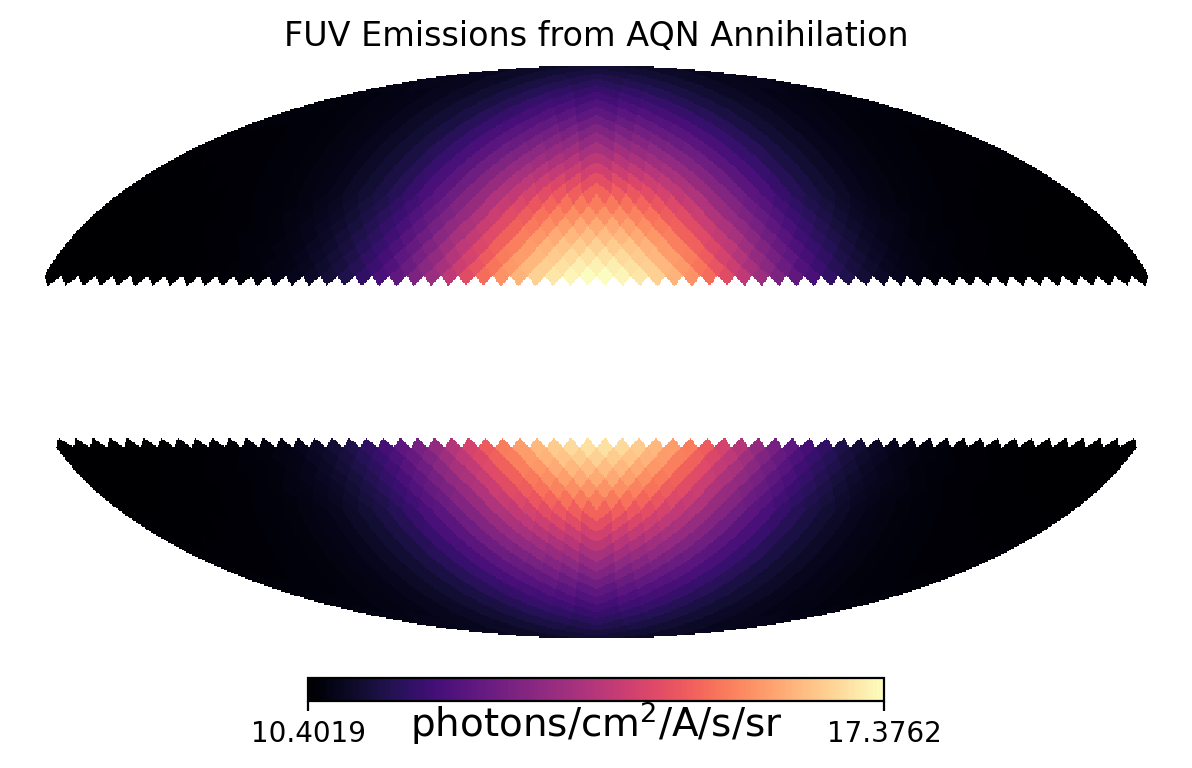

In [46]:
f1 = plt.figure(figsize=(6, 4), dpi=200)
# rotation in (lat, long, psi)
hp.mollview(np.log(dfdlambda), title="FUV Emissions from AQN Annihilation", rot=(180,0,0),cmap='magma', fig=f1, unit="photons/cm$^2$/A/s/sr")
plt.savefig("skymap_full_band.png")
plt.show()
# 23  24
#flux_array[22] = -2.8750126140481806e-42
#flux_array[25] = -2.8750126140481806e-42

In [31]:
def sum_epsilon(l_min,l_max,theta,phi,nu):
    dfdnu = sum(func(z_array, theta, phi, nu))
    return dfdnu / (4*np.pi) * (dz.cgs).value * dOmega


In [32]:

# erg Hz^-1 s^-1 cm^-2
# nu Hz
# T eV
def spectral_surface_emissivity(nu, T):
    T = T * eV_to_erg
    w = 2 * np.pi * nu * Hz_to_erg
    unit_factor = (1 / cst.hbar.cgs) * (1/(cst.hbar.cgs * cst.c.cgs))**2 * (cst.hbar.cgs * 1/u.Hz * 1/u.s)
    #                ^ 1/seconds           ^ 1/area                          ^ 1/frequency and energy
    #print(np.array(w/T))
    return unit_factor * 4/45 * T**3 * cst.alpha ** (5/2) * 1/np.pi * (T/(m_e_eV*eV_to_erg))**(1/4) * (1 + w/T) * np.exp(- w/T) * h(w/T)


def spectral_spatial_emissivity_cold(n_AQN, n_bar, Dv, f, g, nu):
    t_i = time.time()
    T_AQN = T_AQN_analytical(n_bar, Dv, f, g)
    # print("Time taken 0: ", time.time() - t_i)
    #print(T_AQN)
    #T_AQN = 1 * u.eV ########################################################
    dFdw = spectral_surface_emissivity(nu, T_AQN)
    return dFdw * 4 * np.pi * R_AQN**2 * n_AQN.to(1/u.cm**3)

def spectral_spatial_emissivity_hot(n_AQN, n_bar, Dv, f, g, T_gas, R_AQN, nu):
    t_i = time.time()
    T_AQN = max(T_AQN_analytical(n_bar, Dv, f, g), T_AQN_ionized(n_bar, Dv, f, g, T_gas, R_AQN))
    # print("Time taken: ", time.time() - t_i)
    t_i = time.time()
    dFdw = spectral_surface_emissivity(nu, T_AQN)
    # print("Time taken 2: ", time.time() - t_i)
    return dFdw * 4 * np.pi * R_AQN**2 * n_AQN.to(1/u.cm**3)





def func(l, theta, phi, nu):
    t_tot = time.time()
    t_i = time.time()
    r,z = coord_conv([l, theta, phi])
    # print("1",time.time() - t_i)
    
    t_i = time.time()
    n_cold     = n_gas_component(r,z, "cold")
    #T_cold     = T_gas_cold
    # print("2",time.time() - t_i)
    
    t_i = time.time()
    n_warm     = n_gas_component(r,z, "warm") # avoid setting variables
    T_warm     = T_gas_warm
    # print("3",time.time() - t_i)
    
    t_i = time.time()
    n_warm_hot = n_gas_component(r,z, "warm-hot")
    T_warm_hot = T_gas_warm_hot
    # print("4",time.time() - t_i)
    
    t_i = time.time()
    n_hot      = n_gas_component(r,z, "hot")
    T_hot      = T_gas_hot
    # print("5",time.time() - t_i)
    
    t_i = time.time()
    n_aqn = n_halo(r,z)
    # print("6",time.time() - t_i)
    
    t_i = time.time()
    epsilon = (spectral_spatial_emissivity_cold(n_aqn, n_cold, Dv, f, g, nu) +
               spectral_spatial_emissivity_hot(n_aqn, n_warm,     Dv, f, g, T_warm,     R_AQN, nu) +
               spectral_spatial_emissivity_hot(n_aqn, n_warm_hot, Dv, f, g, T_warm_hot, R_AQN, nu) +
               spectral_spatial_emissivity_hot(n_aqn, n_hot,      Dv, f, g, T_hot, R_AQN, nu))
    return epsilon.value

def response_func(wavelength):
    return 1 #wavelength/(wavel_max - wavel_min).value



def h(x):
    return_array = np.zeros(len(x))
    return_array[np.where(x<1)] = (17 - 12*np.log(x[np.where(x<1)]/2))
    return_array[np.where(x>=1)] = 17 + 12*np.log(2)
    return return_array
def spectral_spatial_emissivity_hot(n_AQN, n_bar, Dv, f, g, T_gas, R_AQN, nu):
    T_neu_eV = T_AQN_analytical(n_bar, Dv, f, g)
    T_ion_eV = T_AQN_ionized(n_bar, Dv, f, g, T_gas, R_AQN)
    #print(T_neu_eV, T_ion_eV)
    T_AQN = T_neu_eV.copy()                   # don't need this, use T_neu_eV
    ion_greater_neu = np.where(T_ion_eV > T_neu_eV)
    T_AQN[ion_greater_neu] = T_ion_eV[ion_greater_neu]
    #print(T_AQN)
    #T_AQN = max(T_AQN_analytical(n_bar, Dv, f, g), T_AQN_ionized(n_bar, Dv, f, g, T_gas, R_AQN))
    
    #T_AQN = 
    
    dFdw = spectral_surface_emissivity(nu, T_AQN)
    return dFdw * 4 * np.pi * R_AQN**2 * n_AQN.to(1/u.cm**3)

def sum_epsilon(l_min,l_max,theta,phi,nu):
    dfdnu = sum(func(z_array, theta, phi, nu))
    return dfdnu / (4*np.pi) * (dz.cgs).value * dOmega

def integrate_band(wavelength, theta, phi, l_max):
    t_i = time.time()
    nu = (cst.c / (wavelength*u.Angstrom).to(u.m)).to(u.Hz) #
    dfdnu = sum_epsilon(0,l_max,theta,phi,nu)          
    dfdlambda = (dfdnu * u.erg/u.s/u.Hz/u.cm**2/u.sr).to(u.photon / u.cm**2 / u.s / u.Angstrom / u.sr, u.spectral_density(wavelength * u.Angstrom)).value
    print("for wavelength ", wavelength,dfdlambda, time.time()-t_i)

    return dfdlambda * response_func(wavelength)
# samp

### Sanity Checks

#### Comparing to Ariel's Paper

In [ ]:
print("dark matter mass density seems to match the paper:\n Expected: 0.3 GeV / cm3, ", 
      "Our result:",(rho_halo(8*u.kpc,0*u.kpc)).to(u.g/u.cm**3) * g_to_GeV)
print("visible matter number density does not match the paper:\n Expected: 150 1 / cm3, ",
      "Our result:", (n_gas(8,0)).to(1/u.cm**3))
print("This causes a mismatch in Temperature:\n Expected: 1 eV, ",
      "Our result:", T_AQN_analytical(n_gas(8,0), Dv, f, g))
(rho_gas(8*u.kpc,0*u.kpc)).to(u.g/u.cm**3)

#### 1. Temperature

In [ ]:
f,g = 1/10, 1/10
n_bar = 1 * 1/u.cm**3
Dv = 10**-3 * u.dimensionless_unscaled
m_AQN = 1 * u.g * g_to_GeV

R_AQN = 10**-5 * u.cm
n_AQN = 1.67*10**-24 * 1/u.cm**3
#  ^^ I don't think T_AQN depends on R_AQN or n_AQN

T_AQN_analytical(n_bar, Dv, f, g)
#print("T_AQN is: ", T_AQN_numerical( n_bar, Dv, f, g))

print(n_AQN)

#### 2. Total Flux Integrated Over All Wavelengths

In [ ]:
# def integral_function(wavel):
#     nu = (cst.c / (wavel*u.Angstrom).to(u.m)).to(u.Hz)    
#     return spectral_spatial_emissivity(n_AQN.to(1/u.m**3) * invm3_to_GeV3, n_bar, Dv, f, g, nu).value

#sci.integrate.quad(integral_function,(10**-18*u.m).to(u.Angstrom).value,(100*u.km).to(u.Angstrom).value)[0] * u.erg / u.s / u.cm**3

n_AQN = 1.28516*10**-38 * u.eV**3 * cm_to_eVinv**3
print(n_AQN)
F_tot(T_AQN_analytical(n_bar, Dv, f, g)) * 4 * np.pi * R_AQN**2 * n_AQN


#### 3. Total Flux @ 1 GHz

In [ ]:
f,g = 1/10, 1/10
n_bar = 1 * 1/u.cm**3
Dv = 10**-3 * u.dimensionless_unscaled
m_AQN = 1 * u.g * g_to_GeV

R_AQN = 10**-5 * u.cm
n_AQN = 1.67*10**-24 * 1/u.cm**3
#  ^^ I don't think T_AQN depends on R_AQN or n_AQN


nu = (1 * u.GHz).to(u.Hz)
spectral_spatial_emissivity(n_AQN, n_bar, Dv, f, g, nu)

#### Integrating to Find Gas Mass

In [ ]:
galaxy_diameter
galaxy_height
kpc_to_m = (1*u.kpc).to(u.m).value

# print(sci.integrate.dblquad(integrate_gas_mass, 0.01, galaxy_diameter.value, lambda z: -galaxy_height.value, lambda z: galaxy_height.value)[0]*2*np.pi)
# print(sci.integrate.dblquad(integrate_gas_mass, -galaxy_height.value, galaxy_height.value, lambda z: 0.01, lambda z: galaxy_diameter.value)[0]*2*np.pi)


In [ ]:
def integrate_gas_mass(r,z):
    return rho_gas(r*u.kpc,z*u.kpc).value * r * kpc_to_m * kpc_to_m

def integrate_gas_mass_radius(z):
    return sci.integrate.quad(integrate_gas_mass, 0, galaxy_diameter.value, (z))[0] * kpc_to_m

print((sci.integrate.quad(integrate_gas_mass_radius,-galaxy_height.value,galaxy_height.value)[0]*2*np.pi*u.kg).to(u.solMass))

print((sci.integrate.quad(integrate_gas_mass_radius,-1,1)[0]*2*np.pi*u.kg).to(u.solMass))

In [ ]:
hp.mollview(np.log(flux_array), title="title", cmap='magma')
plt.show()
# 23  24
#flux_array[22] = -2.8750126140481806e-42
#flux_array[25] = -2.8750126140481806e-42

In [ ]:
n_bar = 0.1 * 1/u.cm**3
R_AQN
Dv


T_AQN_analytical(n_bar, Dv, f, g)



In [ ]:
# cross-check with ludo
T_plasma = 0.8617 * u.eV
T_AQN_ionized(n_bar, Dv, f, g, T_plasma, R_AQN)
nu = 1.26e15 * u.Hz
spectral_surface_emissivity(nu, T_AQN_ionized(n_bar, Dv, f, g, T_plasma, R_AQN))
n_AQN = 5.02 * 10**(-25) * 1/u.cm**3
n_AQN



def spectral_spatial_emissivity_hot(n_AQN, n_bar, Dv, f, g, T_gas, R_AQN, nu):
    T_AQN = T_AQN_ionized(n_bar, Dv, f, g, T_gas, R_AQN)
    #print(T_AQN)
    #T_AQN = 1 * u.eV ########################################################
    dFdw = spectral_surface_emissivity(nu, T_AQN)
    print("--",T_AQN, n_bar)
    return dFdw * 4 * np.pi * R_AQN**2 * n_AQN.to(1/u.cm**3) #                                                    !!!!!!!!!!!!!!!!!!

spectral_spatial_emissivity_hot(n_AQN, n_bar, Dv, f, g, T_plasma, R_AQN, nu) * (1*u.kpc).cgs * 1/(4*np.pi*u.sr) 

### Playing with new Galaxy Model (Arif Babul)

In [ ]:
plot_y = 10**6

print("at 10e-3 r_vir, rho/rho_crit=",plot_y)

from astropy.cosmology import WMAP7   # WMAP 7-year cosmology
rho_crit_z0 = WMAP7.critical_density(0)  # critical density at z = 0  
print("Critical density at redshift z=0 is", rho_crit_z0)
print("So rho=",plot_y * rho_crit_z0)
print("n=",plot_y * rho_crit_z0/cst.m_p.cgs)
print("But Ludo suggests 500 1 / cm3")

In [ ]:
WMAP7.critical_density(0.5)

In [ ]:
spectral_surface_emissivity(1.93e15*u.Hz, 0.5*u.eV)
spectral_surface_emissivity((1*u.GHz).to(u.Hz), 0.1*u.eV)


plt.figure(figsize=(8, 6), dpi=100)

T = np.arange(0.1,1.1,0.02) * u.eV
epsilon = np.zeros(len(T))
for i in range(len(T)):
    epsilon[i] = spectral_surface_emissivity(2e15*u.Hz, T[i]).value
plt.plot(T,epsilon, label="2e6 GHz")


T = np.arange(0.1,1.1,0.02) * u.eV
epsilon = np.zeros(len(T))
for i in range(len(T)):
    epsilon[i] = spectral_surface_emissivity((1*u.GHz).to(u.Hz), T[i]).value
plt.plot(T,epsilon, label="1 GHz")

plt.yscale('log')
plt.xlabel("T [eV]",size=15)
plt.ylabel("dF/dnu [erg/cm$^2\cdot$Hz$\cdot$s]",size=15)
plt.legend()
plt.savefig("spectral_surface_emissivity.png")
plt.show()

In [ ]:
plt.figure(figsize=(6, 4), dpi=150)

import csv
def plotting_function(filename, gas_type, color, A=0, B=0):
    with open(filename, mode='r') as file:
        reader = csv.reader(file, delimiter=",")
        next(reader)
        x = []
        y = []
        for r in reader:
            #print(r[4],r[5],r[6])
            #led_positions.setdefault(r[0],{}).update({r[1]: np.array([r[2], r[3]]).astype(float)})
            x.append(float(r[5]))
            y.append(float(r[6]))
    x = np.array(x)
    y = np.array(y)

    xdata = 10**x
    ydata = 10**y

    plt.scatter(10**x, 10**y, s=7,marker=".",color=color,label=gas_type + " gas")
    
    if A!=0:
        x = np.arange(-3.5,0.5,0.01)
        x_exp = 10**x
        plt.plot(x_exp,A * (x_exp)**B, color=color)

plotting_function("E2K_Gas_Cold.csv", "cold", "blue", 0, 0)
plotting_function("E2K_Gas_Warm.csv", "warm", "green", 0, 0)
plotting_function("E2K_Gas_Warm_Hot.csv", "warm-hot", "red", 0, 0)
plotting_function("E2K_Gas_Hot.csv", "hot", "cyan", 0, 0)


x = np.arange(-3.5,1,0.01)
x_exp = 10**x
# plt.plot(x_exp,A * (x_exp)**B, label="0th order excel fit")
plt.plot(x_exp, a1_c / (1+(x_exp/b1_c)**2)**c1_c + \
                 a2_c / (1+(x_exp/b2_c)**2)**c2_c + \
                 a3_c / (1+(x_exp/b3_c)**2)**c3_c, lw="1", ls="-", color="gray")

plt.plot(x_exp,  a1_w / (1+(x_exp/b1_w)**2)**c1_w + \
                 a2_w / (1+(x_exp/b2_w)**2)**c2_w + \
                 a3_w / (1+(x_exp/b3_w)**2)**c3_w, lw="1", ls="-", color="gray")

plt.plot(x_exp,  a1_wh / (1+(x_exp/b1_wh)**2)**c1_wh + \
                 a2_wh / (1+(x_exp/b2_wh)**2)**c2_wh + \
                 a3_wh / (1+(x_exp/b3_wh)**2)**c3_wh, lw="1", ls="-", color="gray")

plt.plot(x_exp,  a1_h / (1+(x_exp/b1_h)**2)**c1_h + \
                 a2_h / (1+(x_exp/b2_h)**2)**c2_h + \
                 a3_h / (1+(x_exp/b3_h)**2)**c3_h, lw="1", ls="-", color="gray")



plt.plot([r_min_kpc.value,r_min_kpc.value]/r_vir_kpc.value,[10e-6,10e8], label="r$_{min}$")


# def power_law_fit(x, A, B):
#     return A * x**B
# x = np.arange(-3.5,1,0.01)
# x_exp = 10**x
# plt.plot(x_exp,power_law_fit(x_exp, *parameters), label="0th order scipy fit")


plt.yscale('log')
plt.xscale('log')

plt.ylim([1e-2,10e6])
plt.xlabel("r/r_vir",size=15)
plt.ylabel("rho/rho_crit",size=15)
plt.legend()
plt.savefig("E2K_fitted_gas_functions_ratios.png")
plt.show()



### Visualizing MW Baryon and DM Number Density Model


In [ ]:
SIZE = 100
RESOLUTION = 1
z = np.array([-0.3,-0.2,-0.1,0,0.1,0.2,0.3])
x = np.arange(-SIZE, SIZE + 1, RESOLUTION)  # len = 11
y = np.arange(-SIZE, SIZE + 1, RESOLUTION)  # len = 7
n = np.zeros([len(x), len(y)])
c = np.meshgrid(x,y)
R = np.sqrt(c[0]**2 + c[1]**2)

n = n_halo(R,np.zeros([len(x),len(y)])).value  #+ n_bulge(R,np.zeros([len(x),len(y)])).value



fig, axs = plt.subplots(nrows=len(z)+1, ncols=2, figsize = (20,10*len(z)), gridspec_kw={'height_ratios': [0.1] + [1]*len(z)}, dpi=100)

# https://stackoverflow.com/questions/50420553/matplotlib-pyplot-pcolormesh-setting-range-of-colors
norm_gas = matplotlib.colors.Normalize(vmin=0,  vmax= 1400000)
norm_gas = matplotlib.colors.Normalize(vmin=0,  vmax= 190000)
norm_dm = matplotlib.colors.Normalize(vmin=0, vmax=10**-17)
norm_gas = matplotlib.colors.LogNorm()
norm_dm=matplotlib.colors.LogNorm()
m = 100000000000000
M = 0
for k in range(len(z)):
    
    gas = axs[k+1,0].pcolormesh(x, y, n_gas(R,np.ones([len(x),len(y)])*z[k]).cgs.value, cmap=plt.cm.magma, norm=norm_gas)
    axs[k+1,0].set_title("z="+str(z[k])+" [kpc]", size=20)
    axs[k+1,0].tick_params(axis='x', labelsize=14)
    axs[k+1,0].tick_params(axis='y', labelsize=14)

    halo = axs[k+1,1].pcolormesh(x, y, n_halo(R,np.ones([len(x),len(y)])*z[k]).cgs.value, cmap=plt.cm.magma, norm=norm_dm)
    
    axs[k+1,1].tick_params(axis='x', labelsize=14)
    axs[k+1,1].tick_params(axis='y', labelsize=14)
    
    m = min(np.min(n_gas(R,np.ones([len(x),len(y)])*z[k]).value), m)
    M = max(np.max(n_gas(R,np.ones([len(x),len(y)])*z[k]).value), M)
    #print("--", np.max(n_bulge(R,np.ones([len(x),len(y)])*z[k]).value), np.max(n_disk(R,np.ones([len(x),len(y)])*z[k]).value), np.max(n_halo(R,np.ones([len(x),len(y)])*z[k]).value))
    
print(m, M)
plt.colorbar(gas, norm=norm_gas, cax=axs[0,0], orientation = 'horizontal')
plt.colorbar(halo, norm=norm_dm, cax=axs[0,1], orientation = 'horizontal')
axs[0,0].set_title("Gas", size=25)
axs[0,0].tick_params(axis='x', labelsize=14)
axs[0,0].xaxis.get_offset_text().set_size(15)

axs[0,1].set_title("Halo", size=25)
axs[0,1].tick_params(axis='x', labelsize=14)
axs[0,1].xaxis.get_offset_text().set_size(15)

axs[0,0].set_xlabel("Number Density [1/cm$^3$]", size=16)
axs[1,0].set_xlabel("x [kpc]", size=16)
axs[1,0].set_ylabel("y [kpc]", size=16)

plt.savefig("output3.png")

plt.show()

## Investigating integration/summation methods

In [ ]:
def test_function(x):
    # print("ran")
    return a1_c / (1+(x/b1_c)**2)**c1_c + a2_c / (1+(x/b2_c)**2)**c2_c + a3_c / (1+(x/b3_c)**2)**c3_c

def test_func2(x):
    print(np.cos(x))
    return np.cos(x)

x = np.arange(0,25,25/(2**6+1))
res = 20
DX = np.pi/2/(2**res+1)
x2 = np.arange(0,np.pi/2,DX)

#sci.integrate.simpson(test_function(x))

In [ ]:
# t_i = time.time()
# print(sci.integrate.romb(test_func2(x2), dx=DX), time.time()-t_i) # print(sci.integrate.romb(test_func2(x2))*DX, time.time()-t_i)
# t_i = time.time()
# print(sci.integrate.simpson(test_func2(x2), dx=DX), time.time()-t_i)
# t_i = time.time()
# # print(sum(test_func2(x2))*(np.pi/2 / (len(x2)+1)), time.time()-t_i)
# t_i = time.time()
# print(sci.integrate.romberg(test_func2,0,np.pi/2), time.time()-t_i)
# t_i = time.time()
# print(sci.integrate.quad(test_func2,0,np.pi/2)[0], time.time()-t_i)
# t_i = time.time()
# # print(sci.integrate.trapezoid(test_func2(x2), dx=DX), time.time()-t_i)

In [ ]:
plt.plot(x,test_function(x))
#plt.xscale("log")
plt.yscale("log")

In [ ]:
xmin = 0
xmax = 25
res = 2**20+1
DX = (xmax-xmin)/res

x = np.arange(xmin,xmax,DX)

# Fixed sample integration methods:
t_i = time.time()
print("romb", sci.integrate.romb(test_function(x), dx=DX), time.time()-t_i) # print(sci.integrate.romb(test_func2(x2))*DX, time.time()-t_i)
t_i = time.time()
print("simpson", sci.integrate.simpson(test_function(x), dx=DX), time.time()-t_i)
t_i = time.time()
print("trapezoid", sci.integrate.trapezoid(test_function(x), dx=DX), time.time()-t_i)
t_i = time.time()
print("summation", sum(test_function(x))*DX, time.time()-t_i)

print("\n")
# Numerical integration methods:
t_i = time.time()
print("integral romberg", sci.integrate.romberg(test_function,xmin,xmax), time.time()-t_i)
t_i = time.time()
print("integral quad", sci.integrate.quad(test_function,xmin,xmax)[0], time.time()-t_i)